# How to use the algorithm Orthogonal Matching Pursuit - OMP on a DataTime object

The SciDataTool python module has been created to **ease the handling of scientific data**, the DataND's method `orthogonal_mp` allows to recover a signal with missing time samples assuming the signal has a sparse representation in the Fourier space, which means the signal is compressible.

Given a DataTime object, build upon a non uniform axe Data1D, we want to compute the spectrum of the DataTime object.

There are 2 different way to implement this reconstruction:
1. Greedy algorithm / forward feature selection -> OMP
2. Linear system with $l_1$ constraint -> Basis Pursuit

This implementation of the `OMP` uses the greedy function `sklearn.linear_model.orthogonal_mp` from the package `scikit-learn`.

The dictionary used is a concatenation of the DCT - Discrete Cosinus Transform - matrix and of the DST - Discrete Sinus Transform - matrix.

The following explains how to use `DataND.orthogonal_mp` method.


## Decomposition

The use of the DCT and DST matrix is relevant for the following decomposition of the signal $x$:
`orthogonal_mp` can only process real-valued signals:
$$
x(t) = \sum_k a_k \cos(2 \pi f_k t + \phi_k)
$$

With $\cos(x+\phi) = \cos(x)\cos(\phi) - \sin(x)\sin(\phi)$

$$
x(t) = \sum_k a^{\cos}_k \cos(2 \pi f_k t) + \sum_k a^{\sin}_k \sin(2 \pi f_k t)
$$

$$ a^{\cos}_k = a_k \cos(\phi_k) $$
$$ a^{\sin}_k = a_k \sin(\phi_k) $$

This is why the dictionary is a concatenation of the DCT and the DST, the decomposition of the signal y is framed as:

$$ y = Ax $$

Where $A$ is the dictionary and $x \in R^n$ is the sparse representation of $y \in R^m$. This is an underdetermined linear system. A non zero element in $x$ implies to select a column of $A$ into the signal $y$.

In [1]:
from SciDataTool.Classes.DataTime import DataTime
from SciDataTool.Classes.Data1D import Data1D
from SciDataTool.Classes.DataND import DataND
from SciDataTool.Classes.DataFreq import DataFreq

from SciDataTool.Functions.omp import comp_DST

import numpy as np

from math import floor

In [2]:
import scipy.fft as spfft

from sklearn.linear_model import orthogonal_mp

#### Example:
Create a signal of $2$ sinudoids with $n=100$ points, it's then undersampled with only $K=30$% of the grid.

We plot the $2$ signals and the spectrum.

In [3]:
n = 100

t = np.linspace(0,1,n,endpoint=False)

# Create an undersampled time vector with 30% of the initial samples
K = 0.3
m = floor(K*n)
M = np.random.choice(n,m, replace=False)
M.sort()

print("The indices of the samples:")
print(M)
print("{} observed out of {} samples".format(m,n))

The indices of the samples:
[ 3  6  8 11 17 21 27 28 34 42 44 47 48 53 54 63 64 65 66 68 69 70 71 73
 75 80 82 87 90 96]
30 observed out of 100 samples


In [5]:
# Compute a simple 1D signal with 2 sinusoids
signal = np.cos(2*np.pi*4*t+0.2) + 0.5*np.cos(2*np.pi*10*t+2)

# Undersample this signal
signal_under = signal[M]

# Build the SciDataTool objects
Time = Data1D(name="time", unit="s", values=t)
Time_under = Data1D(name="time", unit="s", values=t[M])

Signal = DataTime(
    name="Full signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time],
    values=signal,
    is_real=True,
)

Signal_under = DataTime(
    name="Undersampled",
    symbol="B_r",
    unit="dimless",
    axes=[Time_under],
    values=signal_under,
    is_real=True,
)

c:\users\eomys\documents\eomys\repo\virtual_env\sample\src\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


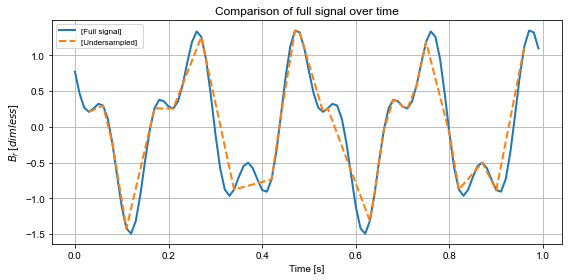

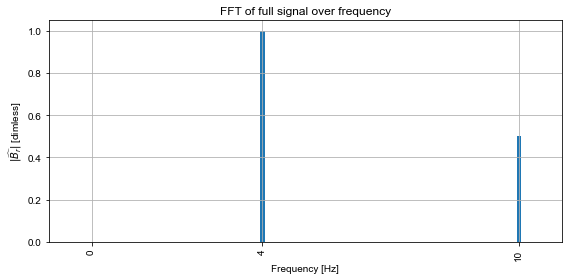

In [6]:
Signal.plot_2D_Data("time",data_list=[Signal_under],linestyles=["-","--"])

Signal.plot_2D_Data("freqs")

Assume we are only given the `Signal_under ` object, which can be the results of a computation or of measurements. We are able to recover an approximation of the object `Signal` through the use of `orthogonal_mp`. This method uses the sparsity of the FFT of `Signal`.

The parameter `n_coefs` is the number of cosinus and sinusoids used in the decomposition of the recovered signal:

$$
x_{OMP}(t) = \sum a^{\cos}_k \cos(2 \pi f_k t) + \sum a^{\sin}_k \sin(2 \pi f_k t)
$$

Using this model, it's obvious that the computed signal in the last cell need to be decomposed with `n_coefs=4`.

Where there are `n_coefs` non zero coefficients $a^{\cos}_k$ and $a^{\sin}_k$

### Recover of the full signal:

c:\users\eomys\documents\eomys\repo\virtual_env\sample\src\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


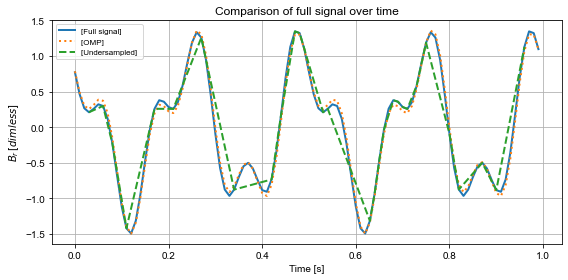

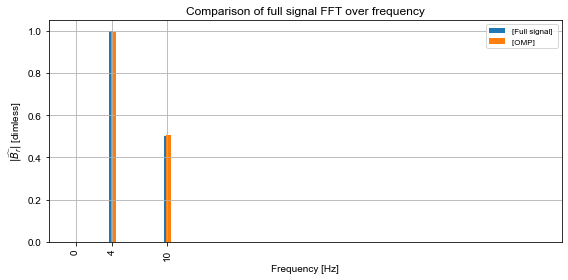

In [7]:
Signal_recover = Signal_under.orthogonal_mp(Time,n_coefs=3)
Signal_recover.name = "OMP"

Signal.plot_2D_Data("time",data_list=[Signal_recover,Signal_under],linestyles=["-",":","--"])
Signal.plot_2D_Data("freqs",data_list=[Signal_recover],is_auto_range=False)

In order to see how the parameter `n_coefs` works, lets see how the reconstruction will improve with more atoms (elements of the dictionary):

In [8]:
magnitude = Signal.get_along("freqs")['B_r']
phase = np.angle(magnitude)
freqs = Signal.get_along("freqs")['freqs']

magnitude_recover = Signal_recover.get_along("freqs")['B_r']
phase_recover = np.angle(magnitude_recover)

indice = np.argsort(np.abs(magnitude))


# Extract the 2 frequencies with the highest energy
freqs = freqs[[indice[-1],indice[-2]]]
phase = phase[[indice[-1],indice[-2]]]
phase_recover = phase_recover[[indice[-1],indice[-2]]]

Freqs = Data1D(name="freqs", unit="Hz", values=freqs)

Phase = DataFreq(
    name="Phase",
    axes=[Freqs],
    values=phase,
)

Phase_recover = DataFreq(
    name="Phase recover",
    axes=[Freqs],
    values=phase_recover,
)



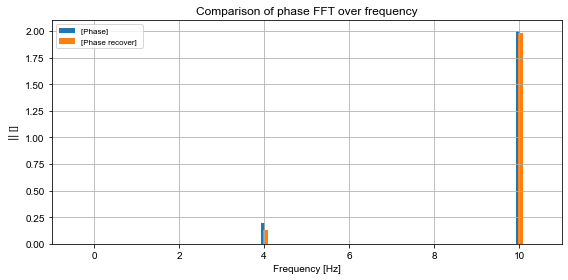

In [9]:
Phase.plot_2D_Data("freqs", linestyles='curve',data_list=[Phase_recover],is_auto_ticks=False)

Using only $3$ atoms, we aren't able to exactly recover the signal, the last elements - with less energy - of the decomposition is missing. The solution is to inrease `n_coefs`.

If this keyword argument `n_coefs` is not provided, it's set to $10/m$. 

$m$ being the length of the signal $y$.

In this example, the `orthogonal_mp` method is used to recover a signal, sum of $2$ cosinus. Using only $2$ atoms the signal is approximately recovered 

### Exact recovering with $4$ atoms:

c:\users\eomys\documents\eomys\repo\virtual_env\sample\src\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


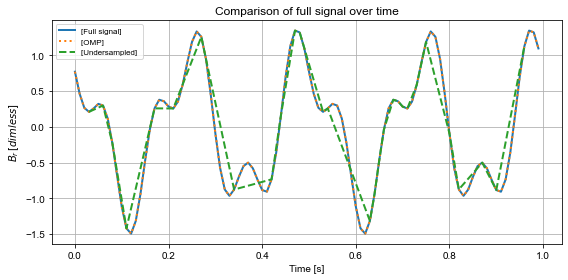

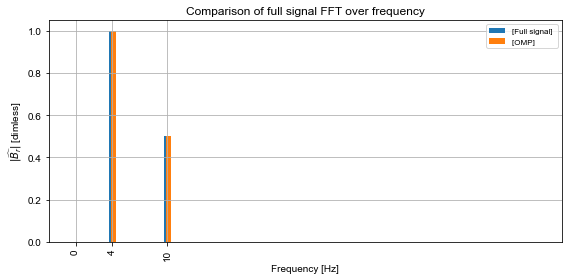

In [11]:
Signal_recover = Signal_under.orthogonal_mp(Time,n_coefs=4)
Signal_recover.name = "OMP"

Signal.plot_2D_Data("time",data_list=[Signal_recover,Signal_under],linestyles=["-",":","--"])
Signal.plot_2D_Data("freqs",data_list=[Signal_recover],is_auto_range=False)

# The dictionary - DCT and DST

Change `i` in order to plot the atoms of the dictionary on which the signal is projected.

(100, 100)


c:\users\eomys\documents\eomys\repo\virtual_env\sample\src\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


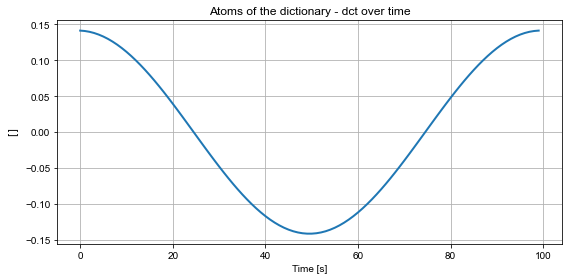

In [12]:
# Compute the dictionary's matrix of the DCT
DCT = spfft.idct(np.identity(n), type=2, norm='ortho', axis=0)

# Plot the i-th column of A -> the i-th atom of the dictionary
i = 2

print(DCT.shape)

axe_time = Data1D(
    name="time",
    values=np.asarray([i for i in range(n)]),
    )

atom = DataTime(
    name="Atoms of the Dictionary - DCT",
    axes=[axe_time],
    values=DCT[:,i],
    )

atom.plot_2D_Data("time")

We will use a dictionary which is the concatenation of the DCT's matrix and the DST's matrix

(100, 100)


c:\users\eomys\documents\eomys\repo\virtual_env\sample\src\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


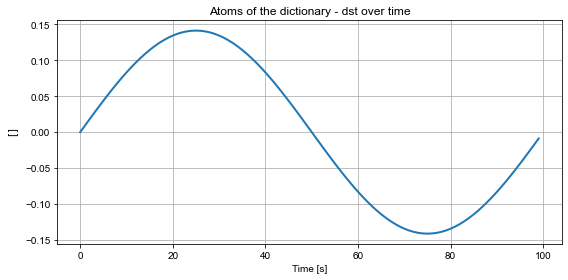

In [13]:
# Compute the dictionary's matrix of the DST
f = 0.5 * np.arange(n)
t = np.linspace(0,1,n,endpoint=False)
DST = np.sin(2 * np.pi * np.outer(f,t))

# Norm the columns of the dictionary
DST = 2 * (1/np.sqrt(2*n)) * DST

# Plot the i-th column of A -> the i-th atom of the dictionary
i = 2

print(DST.shape)

axe_time = Data1D(
    name="time",
    values=np.asarray([i for i in range(n)]),
    )

atom = DataTime(
    name="Atoms of the Dictionary - DST",
    axes=[axe_time],values=DST[:,i],
    )

atom.plot_2D_Data("time")

### Concatenation of the $2$ matrices:

In [14]:
DCT = spfft.idct(np.identity(n), type=2, norm='ortho', axis=0)

f = 0.5 * np.arange(n)
t = np.linspace(0,1,n,endpoint=False)
DST = np.sin(2 * np.pi * np.outer(f,t))

# Norm the columns of the dictionary
DST = 2 * (1/np.sqrt(2*n)) * DST

dictionary = np.concatenate([DCT,DST],axis=1)

print(dictionary.shape)

# a signal of 100 samples is decomposed with a set of cosinus and sinus

(100, 200)


This method recover a time domain signal using its sparse frequency domain representation. Therefore this method uses DST - DCT matrix and process a `DataTime` object.

# Orthogonal Matching Pursuit for SMV - Single Measurement Vector

OMP is a way to solve the following underdetermined linear system:

$$ y = Ax $$

where $A \in R^{m,n}$, $y \in R^m$, $x \in R^n$ and $m << n $
$A$ is the random matrix which models the undersampling.

Assuming the signal has a sparse Fourier Representation, $D$ is the matrix doing the DFT transformation has stated in the last cell.

$$ y = ADX $$

The OMP solve this system minimizing the non zero coefficients of the vector $x$.

The variable `n_coefs` is the number of non zero coefficients searched during the recovering. If set to `None`, `scikit-learn` look for $10/m$ non zero coefficients.

# Orthogonal Matching Pursuit for MMV - Multiple Measurement Vector

Assume we have $\forall i \in \{1,\cdots,n_{targets}\}$

$$ y_i = Ax_i $$

where the $x_i$ vectors are jointly sparse.

We can recover these signals in one use of the OMP, by stacking the vectors $x_i$ and $y_i$ in the columns of the matrix $X$ and $Y$.

$$ Y = AX $$

This can be used to recover 2D signal, for example a time-angle signal.

In [15]:
n = 100

t = np.linspace(0,1,n,endpoint=False)

K = 0.5
m = floor(K*n)
M = np.random.choice(n,m, replace=False)
M.sort()

# Compute a 2D field
def f_2d(t,theta):
    return (
        0
        + 2 * np.cos(6 * 2 * np.pi * t + 20 * theta/360)
        + 1 * np.cos(10 * 2 * np.pi * t + 40 * theta/360)
    )

time = np.linspace(0,1,n,endpoint=False)
angle = np.linspace(0,40,40,endpoint=False)
Time = Data1D(name="time", unit="s", values=time)
Angle = Data1D(name="angle", unit="{°}", values=angle)

time_coord, angle_coord = np.meshgrid(time,angle)
field = f_2d(time_coord,angle_coord).T
Field = DataTime(
    name="Field",
    symbol="X",
    unit="dimless",
    axes=[Time,Angle],
    values=field,
)

Undersample this field and recover the first one with $1$ OMP on the columns of the signals.

In [16]:
time_under = time[M]
Time_under = Data1D(name="time", unit="s", values=time_under)

time_under_coord, angle_under_coord = np.meshgrid(time_under,angle)

field_under = f_2d(time_under_coord,angle_under_coord).T
Field_under = DataTime(
    name="Field under",
    symbol="X",
    unit="dimless",
    axes=[Time_under,Angle],
    values=field_under,
)

Field_recover = Field_under.orthogonal_mp(Time)

C:\Users\Eomys\Documents\eomys\repo\virtual_env\sample\lib\site-packages\sklearn\linear_model\_omp.py:389: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  out = _cholesky_omp(


c:\users\eomys\documents\eomys\repo\virtual_env\sample\src\scidatatool\SciDataTool\Functions\Plot\plot_3D.py:318: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


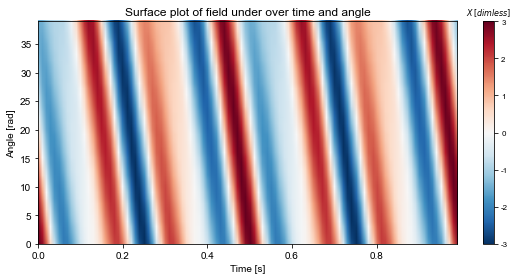

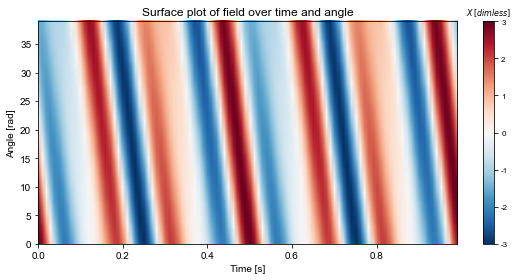

In [17]:
Field_recover.plot_3D_Data("time","angle",is_2D_view=True)
Field.plot_3D_Data("time","angle",is_2D_view=True)

c:\users\eomys\documents\eomys\repo\virtual_env\sample\src\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


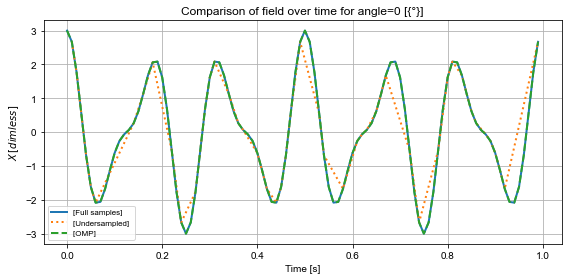

In [18]:
Field.plot_2D_Data("time",data_list=[Field_under,Field_recover],linestyles=["-",":","--"], legend_list=["Full samples","Undersampled","OMP"])

c:\users\eomys\documents\eomys\repo\virtual_env\sample\src\scidatatool\SciDataTool\Functions\Plot\plot_4D.py:249: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


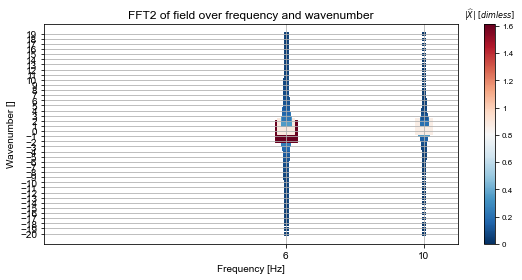

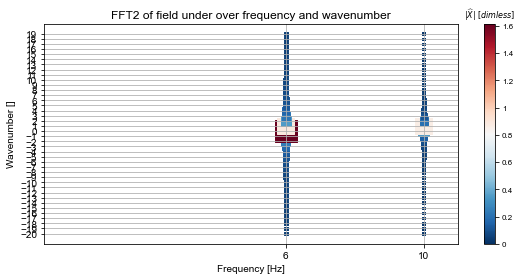

In [19]:
Field.plot_3D_Data("freqs","wavenumber",is_2D_view=True)
Field_recover.plot_3D_Data("freqs","wavenumber",is_2D_view=True)

In [20]:
# Improves performance when the field is very large

Field_recover = Field_under.orthogonal_mp(Time, precompute=True)

TypeError: orthogonal_mp() got an unexpected keyword argument 'precompute'